In [2]:
import os
import xgcm
import gcm_filters
import cmocean
import matplotlib

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from skimage.measure import find_contours
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, Point


datadir = "../data/"

In [3]:
def calculate_gridarea(ds):
    R = 6371e3
    # -- compute cell area -- 
    # -- for each lat/lon grid box gcm-filters needs area in same format as du,dv
    #dy0 = 1852*60*np.abs(ds["lat"][2].dsta - ds["lat"][1].dsta)
    # ** note: dy0 is a constant over the globe ** 
    #dx0 = 1852*60*np.cos(np.deg2rad(ds["lat"].dsta))*(ds["lon"][2].dsta - ds["lon"][1].dsta) 
    dy0 = R*np.pi/180*np.abs(ds["lat"][2].data - ds["lat"][1].data)
    dx0 = R*np.pi/180*np.cos(np.deg2rad(ds["lat"].data))*(ds["lon"][2].data - ds["lon"][1].data)
    
    area = dy0*np.tile(dx0, (len(ds["lon"].data), 1))
    area = np.transpose(area)
    da = xr.DataArray(
        data=area,
        dims=["lat", "lon"],
        coords=dict(
        lon=(["lon"], ds["lon"].data), lat=(["lat"], ds["lat"].data), ),
    )
    return da

def calculate_dx(ds):
    R = 6371e3
    lon, lat = np.meshgrid(ds.lon.data, ds.lat.data)

    dx_array = R*np.pi/180*np.cos(np.deg2rad(lat))*(ds["lon"][2].data - ds["lon"][1].data)
    
    dx = xr.DataArray(
        data=dx_array,
        dims=["lat", "lon"],
        coords=dict(
        lon=(["lon"], ds["lon"].data), lat=(["lat"], ds["lat"].data), ),
    )
    return dx

def calculate_dy(ds):
    R = 6371e3

    dy_array = R*np.pi/180*(ds["lat"][2].data - ds["lat"][1].data)
    dy = xr.DataArray(
        data=dy_array,
        dims=["lat", "lon"],
        coords=dict(
        lon=(["lon"], ds["lon"].data), lat=(["lat"], ds["lat"].data), ),
    )
    return dy

In [4]:
da = xr.open_dataarray(datadir + "bathymetry.nc")
da

<xarray.DataArray 'depth' (lat: 900, lon: 10800)>
[9720000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 60.0 60.03 60.07 60.1 ... 89.87 89.9 89.93 89.97
  * lon      (lon) float32 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [7]:
filter_scale_km = 100

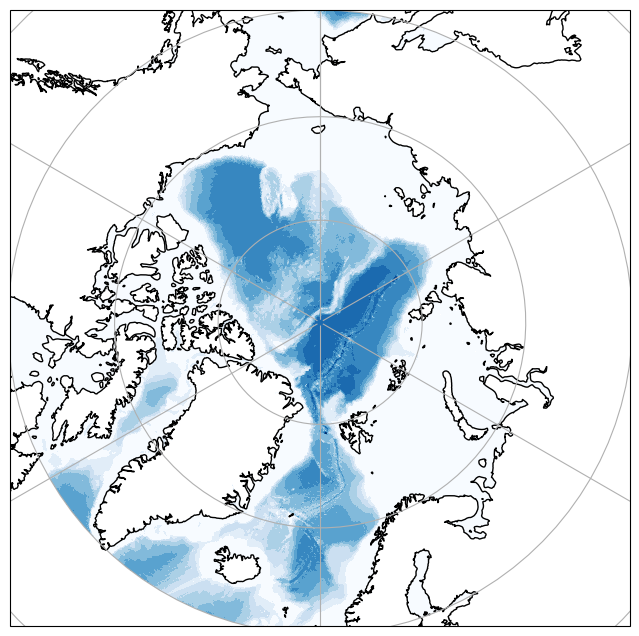

In [6]:
fig, ax = plt.subplots(1, 1,
                       figsize=(10, 8),
                       subplot_kw={"projection" : ccrs.NorthPolarStereo()}
                      )
ax.coastlines()
ax.gridlines()
#ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-180,180,60,90], crs=ccrs.PlateCarree())


cmap = plt.get_cmap('Blues', 10)

c = ax.pcolormesh(da.lon, da.lat, da.isel(lon=slice(0, -1), lat=slice(0, -1)), 
                  shading='flat',
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=5600,
                  cmap=cmap,
                  rasterized=True
           )



In [ ]:
dxs = calculate_dx(da)
dxs = xr.where(dxs > 0, dxs, 0)
dxw = dxs
dys = calculate_dy(da)
dyw = dys
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values


dA = calculate_gridarea(da)

kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

# -- choose a filtering scale -- 
filter_scale = filter_scale_km*1e3
dx_min = dx_min

wetMask = xr.where(np.isnan(da), 0, 1)

filter_50km = gcm_filters.Filter(
                                filter_scale=filter_scale,
                                dx_min=dx_min,
                                filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                                grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
                                grid_vars={
                                            'wet_mask': wetMask, 
                                            'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': dA, 
                                            'kappa_w': kappa_w, 'kappa_s': kappa_s
                                            }
                                    )

In [ ]:
da_filter = filter_50km.apply(da, dims=["lat", "lon"])

In [ ]:
da_filter.to_netcdf(datadir + "bathymetry_filter100.nc")